# Exploring and Plotting the different BOSS Spectra Coadds and their Model Fits

## Learning Goals
By the end of this tutorial, you will:
- Have a basic understanding of the available BOSS coadds available in DR19
- Know how to retrieve SDSS spectrum files
- Understand some of the structure of a fits file containing a BOSS spectrum

## Introduction
SDSS-V now uses the BOSS optical spectrograph to observe stars, galaxies, and quasars. The different science cases have different requirements which led to multiple coadding schema in SDSS-V.

In this short tutorial we will briefly cover how to determine the best coadding product for your science case, and retreive the associated spectra files from the SDSS Science Archive Server (SAS). 

### Imports
This tutorial requires three commonly used python packages, and an SDSS specific package
- `numpy` for doing large array operations
- `matplotlib` for plotting
- `astropy` for reading fits files and tables (and optionally used to download the supplemental files)
- `pydl` used for filtering the summary files based on the bitmasks
- `os` used for accessing environmental variables (optinal if not using astropy to download the supplemental files)
- `sdss_access` for download the sdss data and building the file paths (this can be manually down if desired, but this is not shown here)

Missing packages can be installed via `pip install numpy matplotlib astropy pydl sdss-access`

#### **Note!**
If you already have `sdss_access` installed but have trouble with these file types, try upgrading to the latest version `pip install --upgrade sdss-access sdss-tree`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, Row
from astropy.io import fits
from astropy.utils.data import download_file
from pydl.pydlutils import sdss
import os

from sdss_access import Access
access = Access(release='DR19', verbose=False)

run2d = 'v6_1_3' # The Run2d version of the BOSS Pipeline used for DR19


## Determining the BOSS Coadding Schema
The BOSS pipeline produces 3 types of coadds: Daily, Field Epoch, and Allepoch

### Daily
The Daily coadd spectra are a new product added for DR19. In this schema, all exposures of field taken on a single MJD, are combined. These are optimized if you are looking at short cadence variations.

### Field Epoch
The Field epoch coadd spectra are analogous to the old plate coadding schema. In this strategy, all spectra taken of a field (or plate plugging) within a set time period are coadded together. In plates (except for some exception cases) this time frame was defined as a single plugging, while in the FPS Field era it is defined by the core science driver of the field (ranging from 1 day to 14 days). These are optimized to supply higher level signal-to-noise, where the short period variations are not expected (or required). All target are included in these coadds, even if the length is only a single MJD. 

### Allepoch
The Allepoch coadd spectra are a new SDSS-V product, and are analogous to the eFeds coadds released in DR18. They are only for a subset of Black Hole Mapper (BHM) extragalactic target (First Carton = '*spiders*’ or ‘*bhm_gua*’ or ‘*bhm_csc*’ or ‘*mwm_erosita*’ or ‘*bhm_colr_galaxies*’). 

While preserving basically the same datamodel as the daily and field epoch coadds, these are produced in a fundamentally different way. Here, the coadds are produced on a target level rather then a field level, and a optimized to support the science of these non-variable or ( minimal variation ) targets that require higher signal-to-noise then typically produced in a single visit.


## Selecting visits of target
The spAll-lite summary file can be used to find the visits of a target. If you want the additional exposure level metadata, you can download the spAll (spAll, spAll_epoch, or spAll_coadd) instead, but for most use cases the spAll-lite will be adequate and so it is used for this example.

In [2]:
access.remote()
spAll_file = access.add('spAll-lite', run2d=run2d)
#spAll_file = access.add('spAll-lite_epoch', run2d=run2d)
#spAll_file = access.add('spAll-lite_coadd', run2d=run2d, coadd='allepoch')
access.set_stream()
access.commit()
access.reset() 

Progress:   0%|                                                | 0/1 [00:00<?, ?files/s, n_files=1, n_streams=1]

SDSS_ACCESS> Done!


In this example we will use the daily coadds, but can be expanded to the Field epoch and allepoch coadds

In [3]:
spAll_file = access.full('spAll-lite', run2d=run2d)
#spAll_file = access.add('spAll-lite_epoch', run2d=run2d)
#spAll_file = access.add('spAll-lite_coadd', run2d=run2d, coadd='allepoch')
print(spAll_file)
access.exists('', full=spAll_file)

/Users/jdonor/sas/dr19/spectro/boss/redux/v6_1_3/spAll-lite-v6_1_3.fits.gz


True

In [4]:
spAll_daily = Table.read(spAll_file)

In [5]:
catalogid = 27021597842439106
selection = spAll_daily[(spAll_daily['CATALOGID']==catalogid) & (spAll_daily['SN_MEDIAN_ALL'] > 3)]
selection

FIELD,MJD,MJD_FINAL,OBS,RUN2D,RUN1D,NEXP,EXPTIME,TARGET_INDEX,SPEC_FILE,PROGRAMNAME,SURVEY,CADENCE,FIRSTCARTON,SDSS5_TARGET_FLAGS,OBJTYPE,CATALOGID,CATALOGID_V0,CATALOGID_V0P5,SDSS_ID,SPECOBJID,CALIBFLUX,CALIBFLUX_IVAR,OPTICAL_PROV,MAG,PSFMAG,FIBER2MAG,CATDB_MAG,GAIA_G_MAG,GRI_GAIA_TRANSFORM,BP_MAG,RP_MAG,GAIA_ID,WISE_MAG,TWOMASS_MAG,GUVCAT_MAG,EBV,EBV_TYPE,FIBER_RA,FIBER_DEC,PLUG_RA,PLUG_DEC,RACAT,DECCAT,COORD_EPOCH,PMRA,PMDEC,PARALLAX,DELTA_RA,DELTA_DEC,FIBER_OFFSET,LAMBDA_EFF,HEALPIX,HEALPIXGRP,FIELDQUALITY,EXP_DISP_MED,FIELDSN2,SPEC1_G,SPEC1_R,SPEC1_I,SPEC2_G,SPEC2_R,SPEC2_I,SN_MEDIAN,SN_MEDIAN_ALL,AIRMASS,SEEING20,SEEING50,SEEING80,MOON_DIST,MOON_PHASE,ASSIGNED,ON_TARGET,VALID,DECOLLIDED,ANYANDMASK,ANYORMASK,SPECPRIMARY,SPECBOSS,BOSS_SPECOBJ_ID,NSPECOBS,SPECTROFLUX,SPECTROFLUX_IVAR,SPECTROSYNFLUX,SPECTROSYNFLUX_IVAR,SPECTROSKYFLUX,WAVEMIN,WAVEMAX,WCOVERAGE,CLASS,SUBCLASS,Z,Z_ERR,ZWARNING,RCHI2,DOF,RCHI2DIFF,TFILE,VDISP,VDISP_ERR,VDISPZ,VDISPZ_ERR,VDISPCHI2,VDISPNPIX,VDISPDOF,CHI68P,Z_NOQSO,Z_ERR_NOQSO,ZNUM_NOQSO,ZWARNING_NOQSO,CLASS_NOQSO,SUBCLASS_NOQSO,RCHI2DIFF_NOQSO,XCSAO_RV,XCSAO_ERV,XCSAO_RXC,XCSAO_TEFF,XCSAO_ETEFF,XCSAO_LOGG,XCSAO_ELOGG,XCSAO_FEH,XCSAO_EFEH
int64,int64,float64,bytes3,bytes6,bytes6,int64,float32,int64,bytes42,bytes13,bytes13,bytes13,bytes48,uint8[32],bytes16,int64,int64,int64,int64,bytes29,float32[5],float32[5],bytes26,float32[5],float32[5],float32[5],float32[5],float32,int64,float32,float32,int64,float32[4],float32[3],float32[2],float32,bytes14,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,int64,float32,int64,int64,bytes4,float64,float32,float32,float32,float32,float32,float32,float32,float32[5],float32,float32,float32,float32,float32,float32,float32,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float32[5],float32[5],float32[5],float32[5],float32[5],float32,float32,float32,bytes6,bytes21,float32,float32,int64,float32,int64,float32,bytes24,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,int64,int64,bytes6,bytes21,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
101202,60065,60065.28449126173,APO,v6_1_3,v6_1_3,1,900.0,297,spec-101202-60065-27021597842439106.fits,bhm_filler,BHM,bright_2x1,bhm_gua_bright,0 .. 0,science,27021597842439106,--,27021597842439106,68995788,--,0.0 .. 87.07629,0.0 .. 0.0,sdss_psfmag_from_gaiadr2,-- .. 18.475744,-- .. 17.65225,-- .. 18.475744,-- .. 17.65225,17.667044,0,17.669954,17.31582,2255180988037425792,13.174 .. 7.468,16.601 .. 14.924,19.5055 .. 18.6874,0.0591152,SFD,285.81111774613726,65.12902604937386,--,--,285.8111031892812,65.1290217141325,2015.5,-0.0861903,-0.0453737,-0.0341037,0.0,0.0,0,5400.0,9056,9,bad,0.0,1.840648,1.840648,6.0197864,5.286606,0.0,0.0,0.0,2.3736877 .. 5.540198,8.2438135,1.62316,1.437,1.594,1.919,92.8,0.8,1,1,1,0,84475904,256835584,0,0,0,1,61.233063 .. 103.36359,0.042489756 .. 0.042885855,58.55144 .. 94.1137,0.16185926 .. 0.08680591,128.71616 .. 375.24524,3606.6167,10327.613,0.4472,QSO,BROADLINE,0.51586616,0.00012609901,0,1.0789684,4462,1.0588156,spEigenQSO-58596.fits,0.0,0.0,0.0,0.0,0.0,0.0,0,0.9491671,0.91475487,0.0005666074,2,4,GALAXY,,0.0009012222,367.246,33.802456,1.5329974,3158.7625,1491.7493,3.3209763,1.2073305,-0.4019344,1.0295823
101202,60095,60095.327508183684,APO,v6_1_3,v6_1_3,2,1800.0,180,spec-101202-60095-27021597842439106.fits,bhm_filler,BHM,dark_1x4,bhm_gua_dark,0 .. 0,science,27021597842439106,--,27021597842439106,68995788,--,0.0 .. 87.07629,0.0 .. 0.0,sdss_psfmag_from_gaiadr2,-- .. 18.475744,-- .. 17.65225,-- .. 18.475744,-- .. 17.65225,17.667044,0,17.669954,17.31582,2255180988037425792,13.174 .. 7.468,16.601 .. 14.924,19.5055 .. 18.6874,0.059115518,SFD,285.8111565410277,65.12902804991552,--,--,285.8111031892812,65.1290217141325,2015.5,-0.0861903,-0.0453737,-0.0341037,0.0,0.0,0,5400.0,9056,9,bad,13.00257886272908,1.3282832,1.3282832,6.2918587,3.7958698,0.0,0.0,0.0,5.8534417 .. 7.142995,11.357151,1.41139,1.4045,1.

If you want to select on the ZWARNING Flags, this can be done with the pydl package and the mask bits, which are stored in ILDutils. The full list of bits, with descriptions can be found at https://sdss.org/dr19/data_access/bitmasks/#ZWARNING

In [6]:
#the latest version
#baseurl = 'https://raw.githubusercontent.com/sdss/idlutils/refs/heads/master/data/sdss/sdssMaskbits.par' 
#maskbitfile = download_file(baseurl, cache='update')

#the DR19 version
baseurl = 'https://raw.githubusercontent.com/sdss/idlutils/refs/tags/6.3.0/data/sdss/sdssMaskbits.par' 
maskbitfile = download_file(baseurl, cache='update')

#Pre-existing IDLutils install
#maskbitfile = os.getenv("IDLUTILS_DIR")+"/data/sdss/sdssMaskbits.par"

sdss.set_maskbits(maskbits_file=maskbitfile)
mask = sdss.sdss_flagval('ZWARNING',['UNPLUGGED','BAD_TARGET','NODATA'])
selection[(selection['ZWARNING'] & mask) == 0]

#Another example, where we select spectra that have the SMALL_DELTA_CHI2 (and only that) flag set in ZWARNING
#mask = sdss.sdss_flagval('ZWARNING',['SMALL_DELTA_CHI2'])
#selection[(selection['ZWARNING'] == mask)]

FIELD,MJD,MJD_FINAL,OBS,RUN2D,RUN1D,NEXP,EXPTIME,TARGET_INDEX,SPEC_FILE,PROGRAMNAME,SURVEY,CADENCE,FIRSTCARTON,SDSS5_TARGET_FLAGS,OBJTYPE,CATALOGID,CATALOGID_V0,CATALOGID_V0P5,SDSS_ID,SPECOBJID,CALIBFLUX,CALIBFLUX_IVAR,OPTICAL_PROV,MAG,PSFMAG,FIBER2MAG,CATDB_MAG,GAIA_G_MAG,GRI_GAIA_TRANSFORM,BP_MAG,RP_MAG,GAIA_ID,WISE_MAG,TWOMASS_MAG,GUVCAT_MAG,EBV,EBV_TYPE,FIBER_RA,FIBER_DEC,PLUG_RA,PLUG_DEC,RACAT,DECCAT,COORD_EPOCH,PMRA,PMDEC,PARALLAX,DELTA_RA,DELTA_DEC,FIBER_OFFSET,LAMBDA_EFF,HEALPIX,HEALPIXGRP,FIELDQUALITY,EXP_DISP_MED,FIELDSN2,SPEC1_G,SPEC1_R,SPEC1_I,SPEC2_G,SPEC2_R,SPEC2_I,SN_MEDIAN,SN_MEDIAN_ALL,AIRMASS,SEEING20,SEEING50,SEEING80,MOON_DIST,MOON_PHASE,ASSIGNED,ON_TARGET,VALID,DECOLLIDED,ANYANDMASK,ANYORMASK,SPECPRIMARY,SPECBOSS,BOSS_SPECOBJ_ID,NSPECOBS,SPECTROFLUX,SPECTROFLUX_IVAR,SPECTROSYNFLUX,SPECTROSYNFLUX_IVAR,SPECTROSKYFLUX,WAVEMIN,WAVEMAX,WCOVERAGE,CLASS,SUBCLASS,Z,Z_ERR,ZWARNING,RCHI2,DOF,RCHI2DIFF,TFILE,VDISP,VDISP_ERR,VDISPZ,VDISPZ_ERR,VDISPCHI2,VDISPNPIX,VDISPDOF,CHI68P,Z_NOQSO,Z_ERR_NOQSO,ZNUM_NOQSO,ZWARNING_NOQSO,CLASS_NOQSO,SUBCLASS_NOQSO,RCHI2DIFF_NOQSO,XCSAO_RV,XCSAO_ERV,XCSAO_RXC,XCSAO_TEFF,XCSAO_ETEFF,XCSAO_LOGG,XCSAO_ELOGG,XCSAO_FEH,XCSAO_EFEH
int64,int64,float64,bytes3,bytes6,bytes6,int64,float32,int64,bytes42,bytes13,bytes13,bytes13,bytes48,uint8[32],bytes16,int64,int64,int64,int64,bytes29,float32[5],float32[5],bytes26,float32[5],float32[5],float32[5],float32[5],float32,int64,float32,float32,int64,float32[4],float32[3],float32[2],float32,bytes14,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,int64,float32,int64,int64,bytes4,float64,float32,float32,float32,float32,float32,float32,float32,float32[5],float32,float32,float32,float32,float32,float32,float32,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float32[5],float32[5],float32[5],float32[5],float32[5],float32,float32,float32,bytes6,bytes21,float32,float32,int64,float32,int64,float32,bytes24,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,int64,int64,bytes6,bytes21,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
101202,60065,60065.28449126173,APO,v6_1_3,v6_1_3,1,900.0,297,spec-101202-60065-27021597842439106.fits,bhm_filler,BHM,bright_2x1,bhm_gua_bright,0 .. 0,science,27021597842439106,--,27021597842439106,68995788,--,0.0 .. 87.07629,0.0 .. 0.0,sdss_psfmag_from_gaiadr2,-- .. 18.475744,-- .. 17.65225,-- .. 18.475744,-- .. 17.65225,17.667044,0,17.669954,17.31582,2255180988037425792,13.174 .. 7.468,16.601 .. 14.924,19.5055 .. 18.6874,0.0591152,SFD,285.81111774613726,65.12902604937386,--,--,285.8111031892812,65.1290217141325,2015.5,-0.0861903,-0.0453737,-0.0341037,0.0,0.0,0,5400.0,9056,9,bad,0.0,1.840648,1.840648,6.0197864,5.286606,0.0,0.0,0.0,2.3736877 .. 5.540198,8.2438135,1.62316,1.437,1.594,1.919,92.8,0.8,1,1,1,0,84475904,256835584,0,0,0,1,61.233063 .. 103.36359,0.042489756 .. 0.042885855,58.55144 .. 94.1137,0.16185926 .. 0.08680591,128.71616 .. 375.24524,3606.6167,10327.613,0.4472,QSO,BROADLINE,0.51586616,0.00012609901,0,1.0789684,4462,1.0588156,spEigenQSO-58596.fits,0.0,0.0,0.0,0.0,0.0,0.0,0,0.9491671,0.91475487,0.0005666074,2,4,GALAXY,,0.0009012222,367.246,33.802456,1.5329974,3158.7625,1491.7493,3.3209763,1.2073305,-0.4019344,1.0295823
101202,60095,60095.327508183684,APO,v6_1_3,v6_1_3,2,1800.0,180,spec-101202-60095-27021597842439106.fits,bhm_filler,BHM,dark_1x4,bhm_gua_dark,0 .. 0,science,27021597842439106,--,27021597842439106,68995788,--,0.0 .. 87.07629,0.0 .. 0.0,sdss_psfmag_from_gaiadr2,-- .. 18.475744,-- .. 17.65225,-- .. 18.475744,-- .. 17.65225,17.667044,0,17.669954,17.31582,2255180988037425792,13.174 .. 7.468,16.601 .. 14.924,19.5055 .. 18.6874,0.059115518,SFD,285.8111565410277,65.12902804991552,--,--,285.8111031892812,65.1290217141325,2015.5,-0.0861903,-0.0453737,-0.0341037,0.0,0.0,0,5400.0,9056,9,bad,13.00257886272908,1.3282832,1.3282832,6.2918587,3.7958698,0.0,0.0,0.0,5.8534417 .. 7.142995,11.357151,1.41139,1.4045,1.

### Other potential Filters
There are numerous other columns that the spALL(-lite) file can be filtered on. Listed below are some of the common ones:
- _GAIA_ID_ - GAIA DR2 Source ID
- _FIRSTCARTON_ - The SDSS Targeting carton used to select the target for this design
- _SDSS5_TARGET_FLAGS_ - The Full targeting information for the target (using sdss-semaphore to decode - See the Semaphore tutorial)
- _SDSS_ID_ - SDSS-V Unique Target Identifier
- _FIBER_OFFSET_ - Boolean; Fiber offset by design (to exposure on brighter then allowed target) 
- _EXP_DISP_MED_ - Characterizes the dispersion seen between the individual coadded exposures
- _AIRMASS_ - Ivar weighted Mean Airmass
- _SEEING20_, _SEEING50_, _SEEING80_ -  Ivar weighted Mean Seeing percentiles
- _CLASS_ - SPEC1D Classification
- _SUBCLASS_ - SPEC1D sub-Classification
- _Z_ - SPEC1D Redshift
- _Z_NOQSO_ - SPEC1D Redshift (excluding QSO Models)
- _ZWARNING_NOQSO_ - SPEC1D Warning bits (excluding QSO Models)
- _CLASS_NOQSO_ - SPEC1D Classification (excluding QSO Models)
- _SUBCLASS_NOQSO_ - SPEC1D sub-Classification (excluding QSO Models)

### **Note**
While the XCSAO columns (eg _XCSAO_RV_, _XCSAO_TEFF_) are filled for all rows, these are valid only for stellar spectra.

## Retreiving the Spectra
The specFiles uses the catalogid at the time of exposure. If you want to use the sdss_id, you can use the spAll file to crossmatch and get the catalogid. Additionally, as DR19 contains 2 different versions of the catalogid (v0 and v0.5), you can select either by crossmatching via sdss_id, or by searching on CATALOGID_V0 and CATALOGID_V0P5 and then using the CATALOGID column to build the file names. 

In [7]:
catalogid = 27021597842439106

# if you want all of the visits you can do
#mjd   = '*'
#fieldid = '*'

# otherwise you can use the field and MJDs as selected above to get a select visit
mjd = 60095
fieldid = 101202


access.remote()
# Daily Spectra
access.add('specLite', run2d=run2d, fieldid = fieldid, mjd = mjd, catalogid=catalogid)
# Field Epoch Spectra
#access.add('specLite_epoch', run2d=run2d, fieldid = fieldid, mjd = mjd, catalogid=catalogid)
# Allepoch Spectra
#access.add('specLite_coadd', run2d=run2d, coadd = 'allepoch', mjd = mjd, catalogid=catalogid)
access.set_stream()
access.commit()
access.reset()

Progress:   0%|                                                | 0/1 [00:00<?, ?files/s, n_files=1, n_streams=1]

SDSS_ACCESS> Done!


## Plotting the Spectra
Now that you have retreived the specLite files, you can uses sdss_access again, but this time to build the local file paths.

In [8]:
specFile = access.full('specLite', run2d=run2d, fieldid=fieldid, mjd = mjd, catalogid=catalogid)
#specFile = access.full('specLite_epoch', run2d=run2d, fieldid=fieldid, mjd = mjd, catalogid=catalogid)
#specFile = access.full('specLite_coadd', run2d=run2d, coadd='allepoch', mjd = mjd, catalogid=catalogid)
print(specFile)
access.exists('',full=specFile)

/Users/jdonor/sas/dr19/spectro/boss/redux/v6_1_3/spectra/lite/101202/60095/spec-101202-60095-27021597842439106.fits


True

All 3 coadding schema have the same datamodel, where the coadded spectra are stored in HDU1 ('COADD')

In [9]:
spectra = fits.getdata(specFile, 'COADD')
spAll = fits.getdata(specFile,'SPALL')

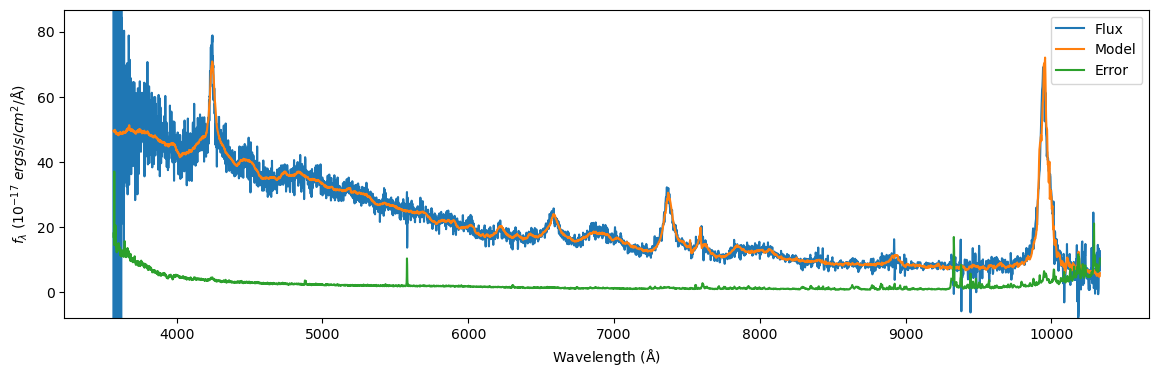

In [10]:
plt.figure(figsize=(14,4))
wave = np.power(10, spectra['LOGLAM'])
mask = (spectra['AND_MASK'] == 0)
plt.plot(wave[mask], spectra['FLUX'][mask], label ='Flux')
plt.plot(wave[mask], spectra['MODEL'][mask], label= 'Model')
error = np.full_like(spectra['IVAR'].data, np.nan)
error[spectra['IVAR'] > 0]  = 1.0/np.sqrt(spectra['IVAR'][spectra['IVAR'] > 0])
plt.plot(wave[mask], error[mask], label='Error')
plt.ylim(np.min(spectra['FLUX'][mask][np.where(wave[mask]>3800)[0]]),
         1.1*np.max(spectra['FLUX'][mask][np.where(wave[mask]>3800)[0]]))
plt.ylabel(r'$f_\lambda~(10^{-17}~ergs/s/cm^2/\mathrm{\AA})$')
plt.xlabel(r'Wavelength $(\mathrm{\AA})$')
plt.legend()
plt.show()

In [11]:
# if you want the spectra in restframe, you can get the redshift (as determined by the model) from 
# the spAll extension and scale the wavelength array accordingly.
print(f"Redshift: {spAll['Z'][0]}")

Redshift: 0.516628086566925


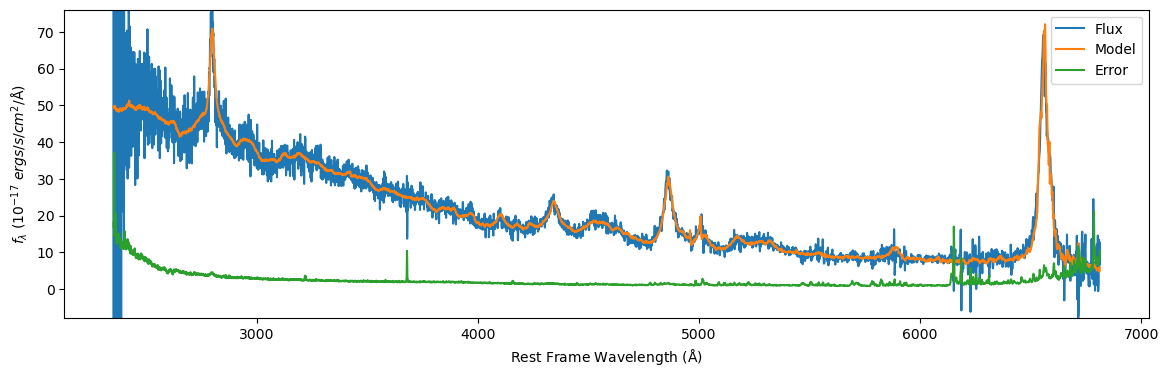

In [12]:
plt.figure(figsize=(14,4))
wave = np.power(10, spectra['LOGLAM'])/(1+spAll['Z'][0])
mask = (spectra['AND_MASK'] == 0)
plt.plot(wave[mask], spectra['FLUX'][mask], label ='Flux')
plt.plot(wave[mask], spectra['MODEL'][mask], label= 'Model')
error = np.full_like(spectra['IVAR'].data, np.nan)
error[spectra['IVAR'] > 0]  = 1.0/np.sqrt(spectra['IVAR'][spectra['IVAR'] > 0])
plt.plot(wave[mask], error[mask], label='Error')
plt.ylim(np.min(spectra['FLUX'][mask][np.where(wave[mask]>3800)[0]]),
         1.1*np.max(spectra['FLUX'][mask][np.where(wave[mask]>3800)[0]]))
plt.ylabel(r'$f_\lambda~(10^{-17}~ergs/s/cm^2/\mathrm{\AA})$')
plt.xlabel(r'Rest Frame Wavelength $(\mathrm{\AA})$')
plt.legend()
plt.show()

### Plotting individual Exposures that are included in the coadded spectra
If you want to plot (or use) the individual extensions that are included in the coadd, you should retreave the specFull versions of the files.

In [13]:
catalogid = 27021597842439106

# if you want all of the visits you can do
#mjd   = '*'
#fieldid = '*'

# otherwise you can use the field and MJDs as selected above to get a select visit
mjd = 60095
fieldid = 101202

access.remote()
# Daily Spectra
access.add('specFull', run2d=run2d, fieldid = fieldid, mjd = mjd, catalogid=catalogid)
# Field Epoch Spectra
#access.add('specFull_epoch', run2d=run2d, fieldid = fieldid, mjd = mjd, catalogid=catalogid)
# Allepoch Spectra
#access.add('specFull_coadd', run2d=run2d, coadd = 'allepoch', mjd = mjd, catalogid=catalogid)
access.set_stream()
access.commit()
access.reset()

Progress:   0%|                                                | 0/1 [00:00<?, ?files/s, n_files=1, n_streams=1]

SDSS_ACCESS> Done!


In [14]:

specFile = access.full('specFull', run2d=run2d,  fieldid=fieldid, mjd = mjd, catalogid=catalogid)
#specFile = access.full('specLite_epoch', run2d=run2d, fieldid=fieldid, mjd = mjd, catalogid=catalogid)
#specFile = access.full('specLite_coadd', run2d=run2d, coadd='allepoch', mjd = mjd, catalogid=catalogid)
print(specFile)
access.exists('',full=specFile)

/Users/jdonor/sas/dr19/spectro/boss/redux/v6_1_3/spectra/full/101202/60095/spec-101202-60095-27021597842439106.fits


True

In [15]:
fits.info(specFile)

Filename: /Users/jdonor/sas/dr19/spectro/boss/redux/v6_1_3/spectra/full/101202/60095/spec-101202-60095-27021597842439106.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     259   ()      
  1  COADD         1 BinTableHDU     34   4648R x 9C   [E, E, E, J, J, E, E, E, E]   
  2  SPALL         1 BinTableHDU    321   1R x 144C   [K, K, 3A, D, 11A, 21A, 6A, 6A, 13A, 11A, I, E, K, 7A, 41A, 10A, 10A, 10A, 28A, 19A, 32B, 16A, K, K, K, K, 28A, 5E, 5E, 25A, 5E, 5E, 5E, 5E, E, K, E, E, K, 4E, 3E, 2E, E, 3A, D, D, D, D, D, D, E, E, E, E, 21A, 19A, 7A, 7A, K, 17A, 17A, E, E, K, K, K, 68A, 3A, D, E, 9A, 9A, 9A, E, E, E, E, E, E, 5E, E, E, E, E, E, 9A, 9A, 3A, 3A, 3A, 3A, K, K, K, K, K, K, 5E, 5E, 5E, 5E, 5E, E, E, E, 6A, 19A, E, E, K, E, K, E, 24A, 10K, K, 10E, E, E, E, E, E, E, K, E, 10E, 10E, 10E, E, E, K, K, 6A, 18A, E, E, E, E, E, E, E, E, E, E]   
  3  ZALL          1 BinTableHDU    135   134R x 56C   [J, J, J, J, K, K, 7A, 6A, 6A, 16A, D, D, 

In [16]:
spectra = fits.getdata(specFile, 'COADD')
spAll = fits.getdata(specFile,'SPALL')
exposures = {}
for exp in range(5,5+spAll['NEXP'][0]):
    name = fits.getval(specFile,'extname',exp)
    exposures[name] = fits.getdata(specFile,exp)
    

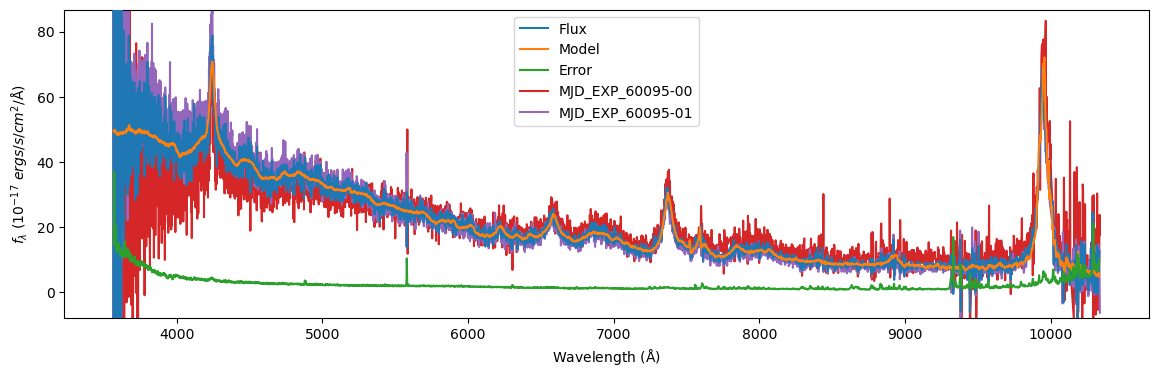

In [17]:
plt.figure(figsize=(14,4))
wave = np.power(10, spectra['LOGLAM'])
mask = (spectra['AND_MASK'] == 0)
plt.plot(wave[mask], spectra['FLUX'][mask], label ='Flux', zorder = spAll['NEXP']+1)
plt.plot(wave[mask], spectra['MODEL'][mask], label= 'Model', zorder = spAll['NEXP']+2)
error = np.full_like(spectra['IVAR'].data, np.nan)
error[spectra['IVAR'] > 0]  = 1.0/np.sqrt(spectra['IVAR'][spectra['IVAR'] > 0])
plt.plot(wave[mask], error[mask], label='Error', zorder = spAll['NEXP']+3)

plt.ylim(np.min(spectra['FLUX'][mask][np.where(wave[mask]>3800)[0]]),
         1.1*np.max(spectra['FLUX'][mask][np.where(wave[mask]>3800)[0]]))


for i, (name, exp) in enumerate(exposures.items()):
    wave = np.power(10, exp['LOGLAM'])
    mask = (exp['AND_MASK'] == 0)
    plt.plot(wave[mask],exp['FLUX'][mask], label=name,zorder=i)

plt.ylabel(r'$f_\lambda~(10^{-17}~ergs/s/cm^2/\mathrm{\AA})$')
plt.xlabel(r'Wavelength $(\mathrm{\AA})$')

plt.legend()
plt.show()

## About this notebook
This notebook was created to illustrate how to find and use the various Coadds of the SDSS-V BOSS spectra

**Authors**: Sean Morrison

**Last Update**: 2025 April 16

If you use astropy for published research, please cite the authors. Follow this link for more information about citing astropy: [Citing `astropy`](https://www.astropy.org/acknowledging.html) 

And of course please [cite](https://sdss.org/collaboration/citing-sdss/) SDSS when you use our data.